# Board Meeting Report
----------------
##### By:
Alejandro Velasquez 

David Rodriguez


- To replicate data, stakeholder should have propper env file

In [1]:
# Imports
import itertools
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math

import env
import os
import wrangle

from sklearn import metrics
from random import randint
from matplotlib import style

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)
#plt.style.use('fivethirtyeight')

In [2]:
df = wrangle.curriculum_logs_data()

In [3]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   id          847330 non-null  float64
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       object 
 14  program_id  847330 non-null  float64
dtypes: float64(3), int64(1), object(11)
memory usage: 103.0+ MB


In [5]:
df = wrangle.wrangle_curriculum_logs_data(df)

In [6]:
df.head(2)

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,start_date,end_date,created_at,updated_at,program_id,date_time,program_name,course
date,,,,,,,,,,,,,,,
2018-01-26,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:55:03,PHP Full Stack Web Development,Web Development
2018-01-26,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1.0,2018-01-26 09:56:02,PHP Full Stack Web Development,Web Development


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 763298 entries, 2018-01-26 to 2021-04-21
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          763298 non-null  datetime64[ns]
 1   time          763298 non-null  object        
 2   endpoint      763298 non-null  object        
 3   user_id       763298 non-null  int64         
 4   cohort_id     763298 non-null  float64       
 5   source_ip     763298 non-null  object        
 6   cohort_name   763298 non-null  object        
 7   start_date    763298 non-null  datetime64[ns]
 8   end_date      763298 non-null  datetime64[ns]
 9   created_at    763298 non-null  datetime64[ns]
 10  updated_at    763298 non-null  object        
 11  program_id    763298 non-null  float64       
 12  date_time     763298 non-null  datetime64[ns]
 13  program_name  763298 non-null  object        
 14  course        763298 non-null  object        
dtypes

## Takeaways
- Data was taken from Codeup 'curriculum_logs' data base
- 900223 records where important
- After wrangleing the data only 763298 will be used for report
----------------------------------------------------


# <center> Management Questions <center>
# 1
**Which lesson appears to attract the most traffic consistently across cohorts (per program)?**

In [8]:
# after going through the contents of the endpoint feature, the following words were 
# identified and need to be removed as these are only elements of the web page or the 
# introductory page
dropped_words = ['/', '.jpg', '.json', '.gif', '.png', '.jpeg', '.svg']

In [9]:
# crate a copy of the intial data frame where we can dropp identified eords in dropped_words
# df_dw = data frame with dropped words taken out
df_dw = df.copy()

In [10]:
# let's remove the words in the dropped_words list
for word in dropped_words:
    df_dw = df_dw[~df_dw['endpoint'].str.endswith(word)]

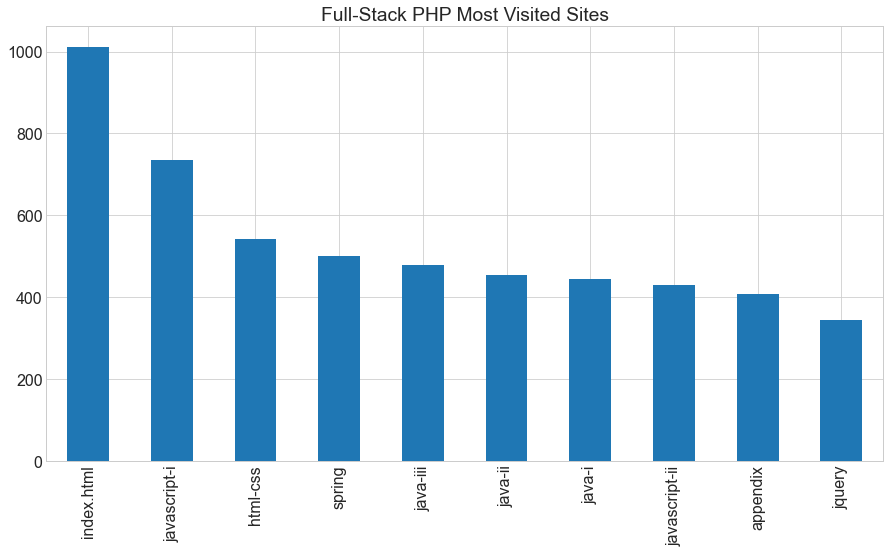

In [11]:
# Top used lessons used by PHP Full Stack Web Development
df_dw[df_dw['program_name'] == 'PHP Full Stack Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Full-Stack PHP Most Visited Sites', figsize = (15,8));

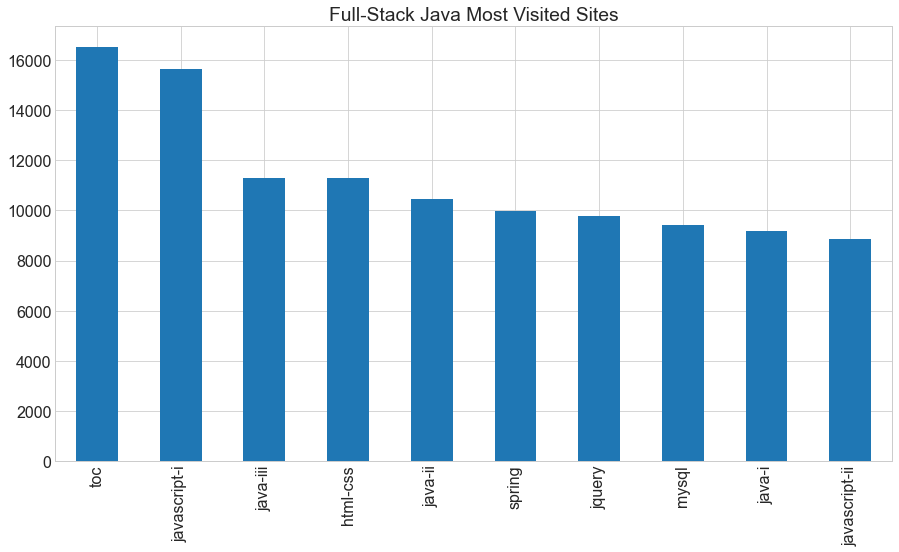

In [12]:
# Top used lessons used by Java Full Stack Web Development
df_dw[df_dw['program_name'] == 'Java Full Stack Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Full-Stack Java Most Visited Sites', figsize = (15,8));

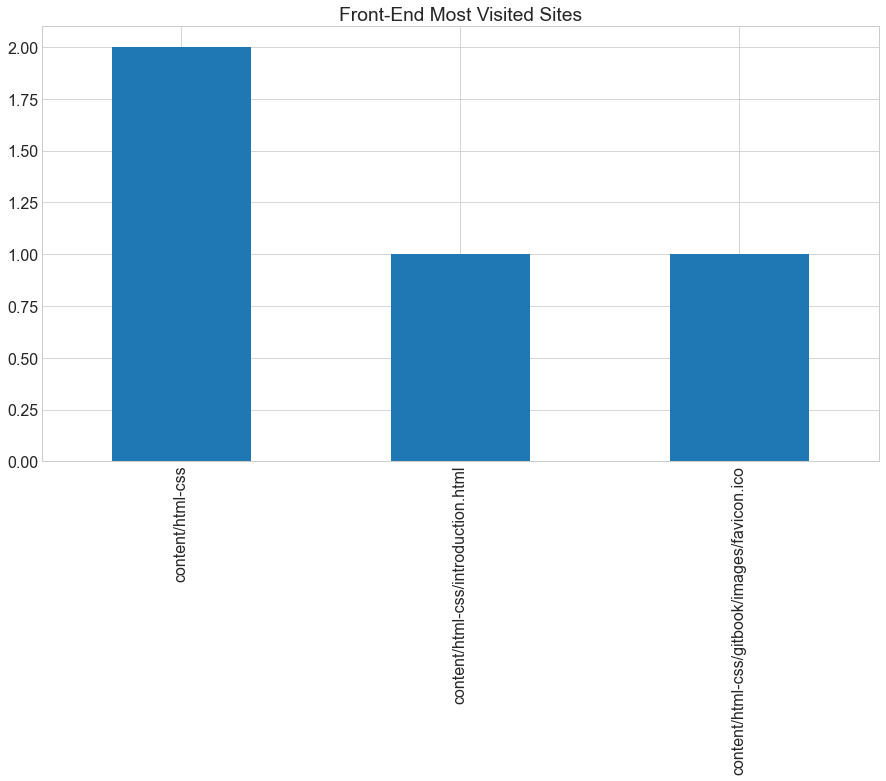

In [13]:
# Top used lessons used by Front-End Most Visited Sites
df_dw[df_dw['program_name'] == 'Front End Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Front-End Most Visited Sites', figsize = (15,8));

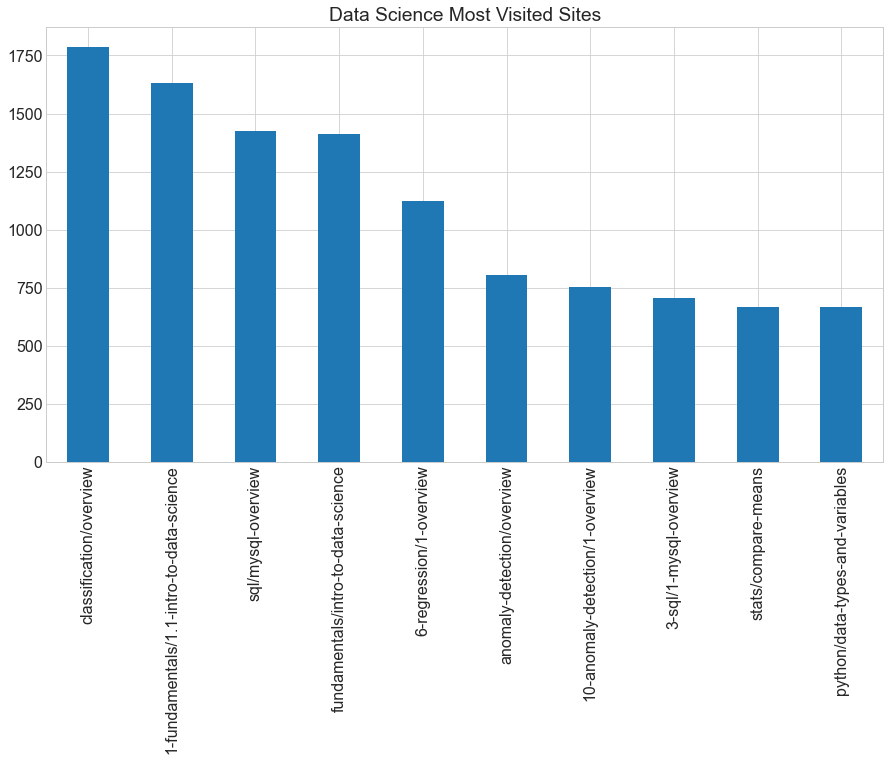

In [14]:
# Top used lessons used by Data Science
df_dw[df_dw['program_name'] == 'Data Science'].endpoint.value_counts().head(10).plot.bar(title = 'Data Science Most Visited Sites', figsize = (15,8));

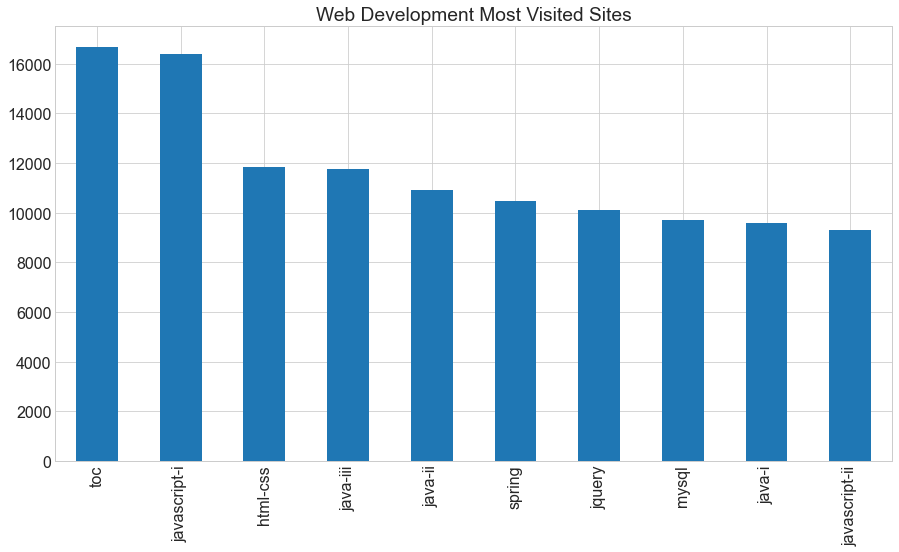

In [15]:
# Top used lessons used by Web Development
df_dw[df_dw['course'] == 'Web Development'].endpoint.value_counts().head(10).plot.bar(title = 'Web Development Most Visited Sites', figsize = (15,8));

# Takeaway 
The lessons that seem to attract more traffic are as follows:
- javascript-i
- java-iii
- java-ii
- toc
- html-css
- classification
- intro to data science
- sql
-------------------------


# 2
**Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?**

In [16]:
with pd.option_context('display.max_rows', None):
    counts = pd.DataFrame(df_dw.groupby('endpoint').cohort_name.value_counts())
    display(counts[counts > 1000].dropna())

cohort_name
endpoint                cohort_name             
classification/overview Darden            1109.0
javascript-i            Ceres             1003.0
toc                     Jupiter           1866.0
                        Zion              1465.0
                        Fortuna           1293.0
                        Hyperion          1022.0

# Takeaway 
The cohorts that seem to reffer to a lesson significantly more than other cohorts are as follows:

- Darden  --> classification/overview with 1109 IPA calls
- Ceres   --> javascript-i with 1003 IPA calls
- Jupiter --> toc with 1866 IPA calls 

-------------------------


# 3
**Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?**

In [17]:
# active students variable contains data on student's activity prior to their program end date
# and the count of their curriculum access while they were students.
active_students = df_dw[df_dw['date'] < df_dw['end_date']].groupby('user_id').endpoint.count().sort_values(ascending = True).to_frame()
active_students = active_students.reset_index()

In [18]:
# last_access holds max values of date, end date and unique user_id  
# last_access contains the last dates the student accessed the curriculum while they were enrolled and prior
# to the end of their program
last_access = pd.DataFrame(columns = ('date', 'user_id', 'end_date'))

In [19]:
# 10% least active students based on active students df count of 727
least_active_students_list = active_students.head(73)
least_active_students_list = list(least_active_students_list.user_id)

In [20]:
# make a data frame that holds all users with low activity
least_active_activity = df_dw[(df_dw['user_id'].isin(least_active_students_list))].sort_values(by = 'user_id')

In [21]:
for user in least_active_activity.user_id.unique():
    # dictinary used in for loop to store values we want to append to last_access df
    a_df = {'date':max(least_active_activity[least_active_activity['user_id'] == user].index), 'user_id':user, 'end_date':max(least_active_activity[least_active_activity['user_id'] == user].end_date)}
    last_access = last_access.append(a_df, ignore_index = True)
    

In [22]:
# data frame contais the 10% least acesss when active
students_with_low_curriculum_access = last_access[last_access.date < last_access.end_date]

In [23]:
students_with_low_curriculum_access.sample(5)

,date,user_id,end_date
54,2021-04-21,960,2021-10-01
9,2018-02-05,49,2018-02-15
68,2021-04-21,975,2021-10-01
67,2021-04-20,974,2021-10-01
40,2020-12-07,832,2021-03-30


# Takeaway 
- Yes there are students that have low access to the curriculum when active
- it is safe to assume that most of these people dropped out from the program
    - We will need more data in time to corroborate
------------------------

# 4
**Is there any suspicious activity, such as users/machines/etc. accessing the curriculum who shouldn't be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?**

In [24]:
# create a dataframe with staff members 
df_ip = wrangle.curriculum_logs_data()

In [25]:
# let's pull the ip addresses of Staff and take them out of the dataframe to identify other
# users accessing the curriculum
staff_ip = list(df_ip[df_ip['name'] == 'Staff'].ip.unique())

In [26]:
# How many stff members ips are there 
len(staff_ip)

318

In [27]:
# nonstaff_ip is a df without the ip addresses of users who accessed the curriculum and are
# classified as staff
nonstaff_ip = df_dw[~df_dw['source_ip'].isin(staff_ip)]

In [28]:
# Groupps the source_ip and the user id
ip_counts = pd.DataFrame(nonstaff_ip.groupby('source_ip').user_id.value_counts())
# counts the users that have an ip count of over 500
ip_counts[ip_counts > 500].dropna().shape[0]

256

In [29]:
# lets get to explore a user
# User 613 accessed the curriculum well over a year after starting the program
max(df_dw[df_dw['user_id'] == 613].index) - min(df_dw[df_dw['user_id'] == 613].index)

Timedelta('395 days 00:00:00')

In [30]:
# let's check hits per minute by creating a copy df and reassigning the index to date_time
# the thinking here goes that if a web scrapper is being used, there would be a lot of 
# endpoint calls in a short span of time
time_index = df_dw.copy()
time_index = time_index.set_index('date_time').sort_index()

# with the new dataframe created, let's see who the top 3 users had the most hits at any 
# given date and time and let's proceed from there
pd.DataFrame(time_index.resample('1Min').user_id.count().sort_values(ascending = False).head(3))

,user_id
date_time,
2019-03-03 22:52:00,169
2019-12-19 23:58:00,125
2018-06-02 15:05:00,84


In [31]:
# let's start with user 169 and see what its activity was for the next 10 minutes
time_index.loc['2019-03-03 22:52:00':'2019-03-03 23:02:00'].groupby('user_id').endpoint.count()

user_id
341    173
Name: endpoint, dtype: int64

In [32]:
# since only one user accessed the curriculu during this time span, let's take a look at
# what was accessed
time_index.loc['2019-03-03 22:52:00':'2019-03-03 23:02:00'].endpoint.count()

173

In [33]:
# We can make sure that user 341 is webscrapign by looking a what they have accessed 
time_index.loc['2019-03-03 22:52:00':'2019-03-03 23:02:00'].endpoint.head(20)

date_time
2019-03-03 22:52:05                                   html-css
2019-03-03 22:52:06                               javascript-i
2019-03-03 22:52:06                                     java-i
2019-03-03 22:52:06                                    java-ii
2019-03-03 22:52:06                              javascript-ii
2019-03-03 22:52:06                                     jquery
2019-03-03 22:52:06                                      mysql
2019-03-03 22:52:06                                   java-iii
2019-03-03 22:52:06                                     spring
2019-03-03 22:52:06                                   appendix
2019-03-03 22:52:06                                        toc
2019-03-03 22:52:06                      html-css/introduction
2019-03-03 22:52:06                             html-css/forms
2019-03-03 22:52:06    html-css/css-i/selectors-and-properties
2019-03-03 22:52:06                html-css/css-i/introduction
2019-03-03 22:52:06                          

In [34]:
# next user
time_index.loc['2019-12-19 23:58:00':'2019-12-20 00:08:00'].groupby('user_id').endpoint.count()

user_id
526    125
Name: endpoint, dtype: int64

In [35]:
# We can make sure that user 526 is webscrapign by looking a what they have accessed 
time_index.loc['2019-12-19 23:58:00':'2019-12-20 00:08:00'].endpoint.head(20)

date_time
2019-12-19 23:58:00                          javascript-ii/npm
2019-12-19 23:58:00                      javascript-ii/modules
2019-12-19 23:58:00                     javascript-ii/ajax-api
2019-12-19 23:58:00                java-i/introduction-to-java
2019-12-19 23:58:00          java-i/syntax-types-and-variables
2019-12-19 23:58:00                          java-i/console-io
2019-12-19 23:58:00        java-i/control-statements-and-loops
2019-12-19 23:58:00        java-ii/object-oriented-programming
2019-12-19 23:58:00                             java-i/strings
2019-12-19 23:58:00                             java-i/methods
2019-12-19 23:58:01                             java-ii/arrays
2019-12-19 23:58:01       java-ii/inheritance-and-polymorphism
2019-12-19 23:58:01    java-ii/interfaces-and-abstract-classes
2019-12-19 23:58:01                        java-ii/collections
2019-12-19 23:58:01                        java-ii/annotations
2019-12-19 23:58:01      java-ii/exceptions-a

In [36]:
# last user
time_index.loc['2018-06-02 15:05:00':'2018-06-02 15:15:00'].groupby('user_id').endpoint.count()

user_id
138    192
Name: endpoint, dtype: int64

In [37]:
# We can make sure that user 138 is webscrapign by looking a what they have accessed 
time_index.loc['2018-06-02 15:05:00':'2018-06-02 15:15:00'].endpoint

date_time
2018-06-02 15:05:00                               content/html-css/css-i
2018-06-02 15:05:01             content/html-css/css-i/introduction.html
2018-06-02 15:05:03    content/html-css/css-i/selectors-and-propertie...
2018-06-02 15:05:05                content/html-css/css-i/box-model.html
2018-06-02 15:05:07              content/html-css/css-i/positioning.html
                                             ...                        
2018-06-02 15:12:31             content/appendix/postwork/locations.html
2018-06-02 15:12:33                content/appendix/postwork/trains.html
2018-06-02 15:12:34             content/appendix/postwork/sales-tax.html
2018-06-02 15:12:35            content/appendix/postwork/mars-rover.html
2018-06-02 15:12:36                        content/postwork/dashboard.md
Name: endpoint, Length: 192, dtype: object

# Takeaways:
- It isn't usual to go through over 100 pages in 10 minutes but some users have loaded more under 10 minutes:
    - user 341
    - user 526
    - user 138
- Since the time spans we are looking at only had one user, we can see what is it that they accessed and how long it took for them to move on from a specific lesson.
- We can conclude that they are users scraping our website
----------------------
 

# 5
At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

In [38]:
# create frame for things that hpapend in 2019
post_2018 = df_dw[df_dw.index >= '2019-01-01']

In [39]:
# create dataframes for different programs that shuld share endpoints
post_2018_ds_students = post_2018[post_2018['course'] == 'Data Science']
post_2018_wb_students = post_2018[post_2018['course'] == 'Web Development']

In [40]:
# create frame for things that hpapend in 2020
post_2019 = df_dw[df_dw.index >= '2020-01-01']

In [41]:
# create dataframes for different programs that shuld NOT share endpoints
post_2019_ds_students = post_2019[post_2019['course'] == 'Data Science']
post_2019_wb_students = post_2019[post_2019['course'] == 'Web Development']

In [42]:
# make two list
# 1 that where the programs are allow to see all endpoints 
# 2 post 2019 where end points should be close
endpoints_2019 = list(post_2018_ds_students.endpoint.unique())
endpoints_2020 = list(post_2019_ds_students.endpoint.unique())

In [43]:
# look for the different endpoints that do not belong to both 
difference = set(endpoints_2020).symmetric_difference(set(endpoints_2019))
list_difference = list(difference)

In [44]:
# crete a list of all endpoints that are not part of the Data science curriculum
java_endpoints = [s for s in list_difference if 'java' in s]

In [45]:
ds_in_webdev_endpoints = post_2018_ds_students[post_2018_ds_students['endpoint'].isin(java_endpoints)]

In [46]:
ds_in_webdev_endpoints.index.max()

Timestamp('2019-12-14 00:00:00')

# Takeaways
- It seems that December 14th of 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off
- To see if this phenomena has happened before we will need more time
----------------------------

# 6
What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [47]:
# Create data frame of graduated students
grads = df_dw[df_dw['date'] > df_dw['end_date']]

In [48]:
# Data Science students referring to the curriculum after graduation
DS_grads = grads[(grads.index > grads['end_date']) & (grads['program_id']== 3.0)]

<AxesSubplot:title={'center':'Data Science Most Visited By Grads'}>

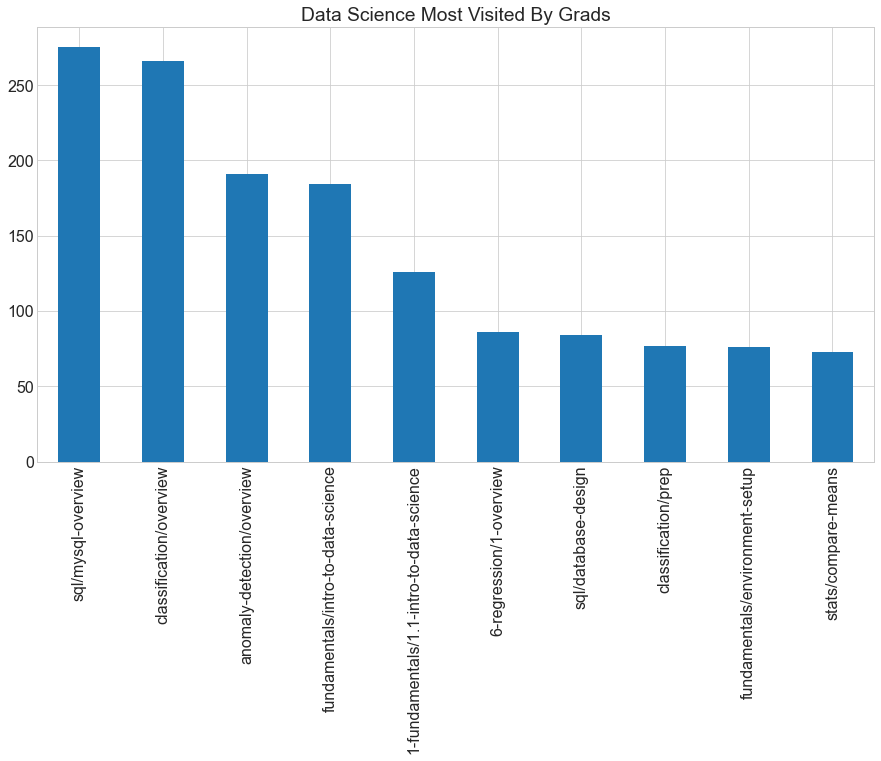

In [49]:
# Plot the top 10 most view topics by grads in Data science 
DS_grads.endpoint.value_counts().head(10).plot.bar(title = 'Data Science Most Visited By Grads', figsize = (15,8))

In [50]:
# Java Full Stack Web Development students referring to the curriculum after graduation
java_full_stack_web_development = grads[(grads.index > grads['end_date']) & (grads['program_id']== 2.0)]

<AxesSubplot:title={'center':'Java Full Stack Web Development Most Visited By Grads'}>

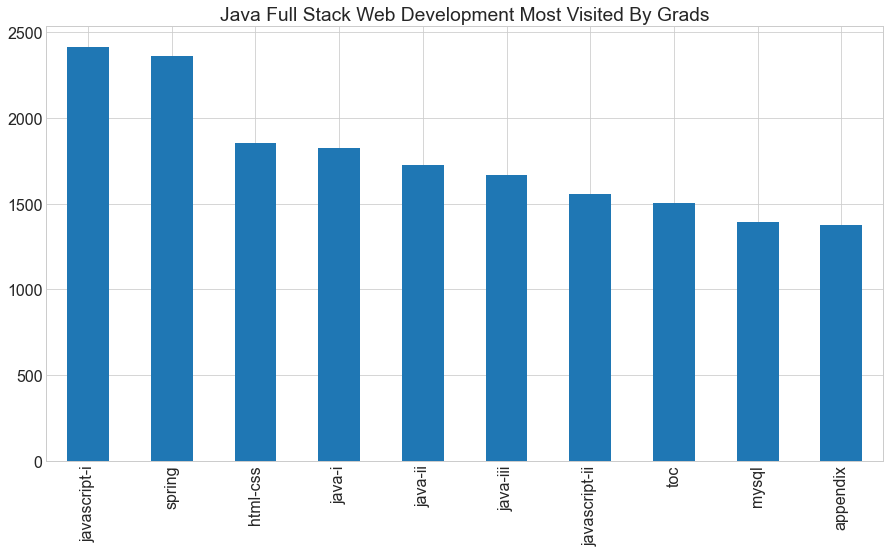

In [51]:
# Plot the top 10 most view topics by grads in Java Full Stack Web Development
java_full_stack_web_development.endpoint.value_counts().head(10).plot.bar(title = 'Java Full Stack Web Development Most Visited By Grads', figsize = (15,8))

In [52]:
# PHP Full Stack Web Development students referring to the curriculum after graduation
PHP_full_stack_web_development = grads[(grads.index > grads['end_date']) & (grads['program_id']== 1.0)]


<AxesSubplot:title={'center':'PHP Full Stack Web Development Most Visited By Grads'}>

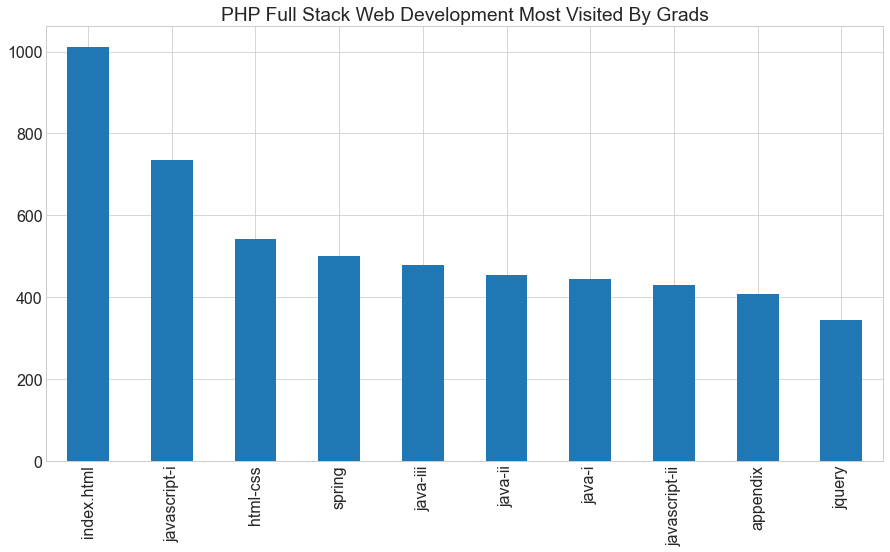

In [53]:
# Plot the top 10 most view topics by grads in PHP Full Stack Web Development
PHP_full_stack_web_development.endpoint.value_counts().head(10).plot.bar(title = 'PHP Full Stack Web Development Most Visited By Grads', figsize = (15,8))

In [54]:
# Front End Web Development students referring to the curriculum after graduation
front_end_web_development = grads[(grads.index > grads['end_date']) & (grads['program_id']== 4.0)]


<AxesSubplot:title={'center':'Front End Web Development Most Visited By Grads'}>

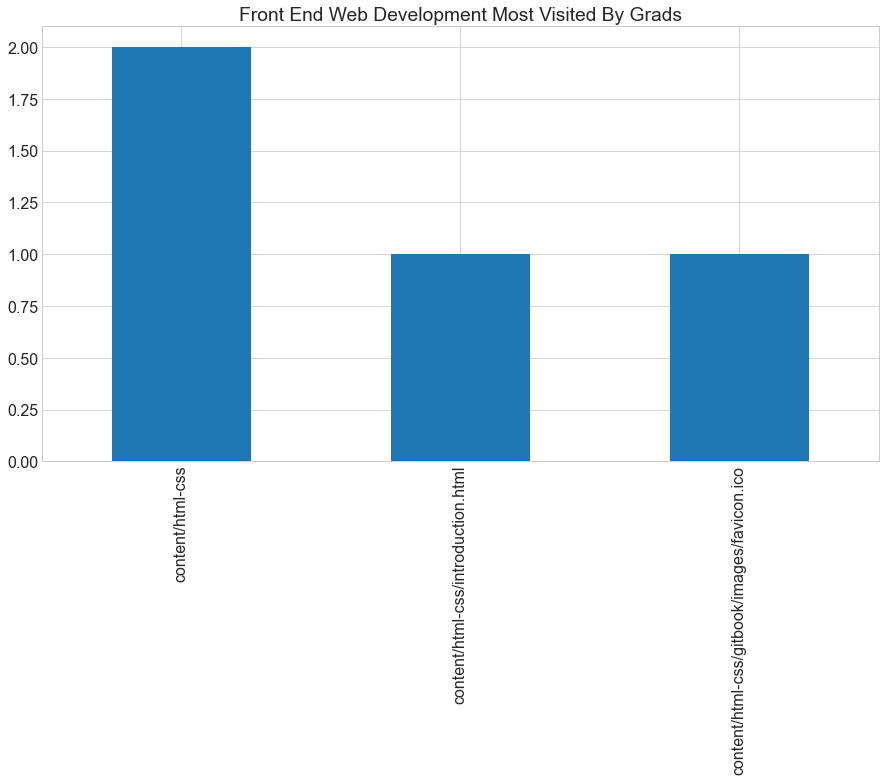

In [55]:
# Plot the view topics by grads in PHP Front End Web Development
front_end_web_development.endpoint.value_counts().head(10).plot.bar(title = 'Front End Web Development Most Visited By Grads', figsize = (15,8))

# Takeaways
- Data Science Grads
    - SQL
    - Classification
    - Anomaly
- Java Full Stack Web Development Grads
    - Java Script
    - Spring
    - HTML CSS
- PHP Full Stack Web Development Grads
    - Index HTML
    - Java Script
    - HTML CSS
- Front End Web Development Grads
    - HTML CSS
----------------------

# 7
Which lessons are least accessed?

In [56]:
# Create series for data science only where we count the accessed endpoints
least_accessed_ds = df_dw[df_dw['program_name'] == 'Data Science'].endpoint.value_counts()

In [57]:
# turn least_accessed seriesn into panda df
least_accessed_ds = pd.DataFrame(least_accessed_ds)
# arrange least_accessed data frame by the count of enpoit 
least_accessed_ds = least_accessed_ds.sort_values('endpoint').index.value_counts().rename('endpoint_count').reset_index()

In [58]:
least_accessed_ds.shape[0]

631

# Takeaway
- 631 endpoints could be classified as the least accessed for data science students.


In [59]:
# Create series for web development records only where we count the accessed endpoints
least_accessed_by_web_developers = df_dw[df_dw['program_name'] != 'Data Science'].endpoint.value_counts();

In [60]:
# turn least_accessed_by_web_developers seriesn into panda df
least_accessed_by_web_developers = pd.DataFrame(least_accessed_by_web_developers)

In [61]:
# arrange least_accessed data frame by the count of enpoit 
least_accessed_by_web_developers = least_accessed_by_web_developers.sort_values('endpoint').index.value_counts().rename('endpoint_count').reset_index()

In [62]:
least_accessed_by_web_developers.shape[0]

1258

# Takeaway
- 1258 endpoints could be classified as the least accessed for web development students.

**In order to obtain the full answer please round the following code lines**

In [63]:
# export least acessed ds topics to csv
# eleimnate markdown in line 3 of this code block to export answer
#least_accessed_ds.to_csv('least_accessed_ds.csv')

In [64]:
# export least acessed wd topics to csv
# eleimnate markdown in line 3 of this code block to export answer
#least_accessed_ds.to_csv('least_accessed_ds.csv')

-----------------------

# 8. 
Anything else I should be aware of?

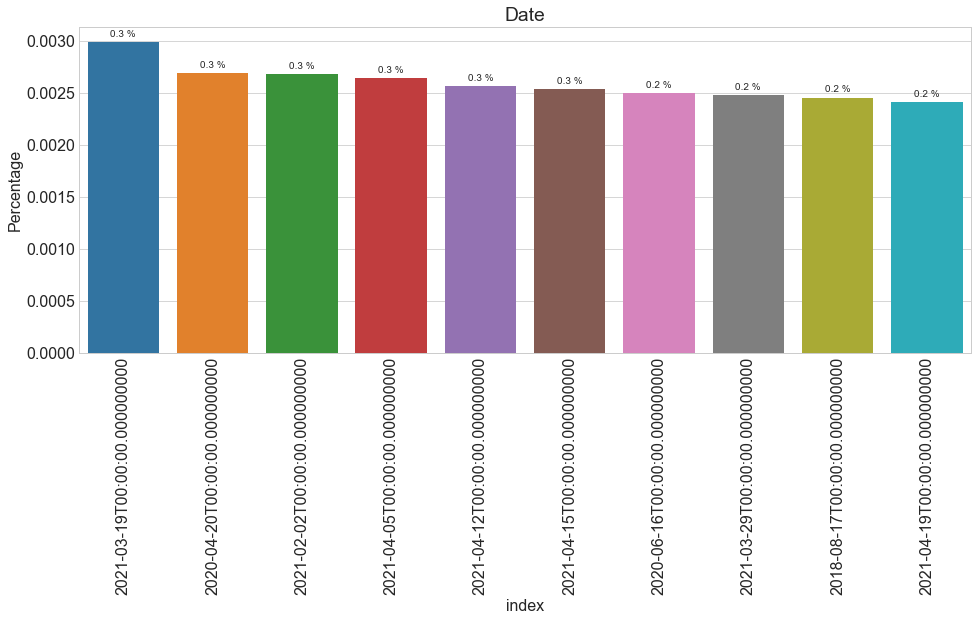

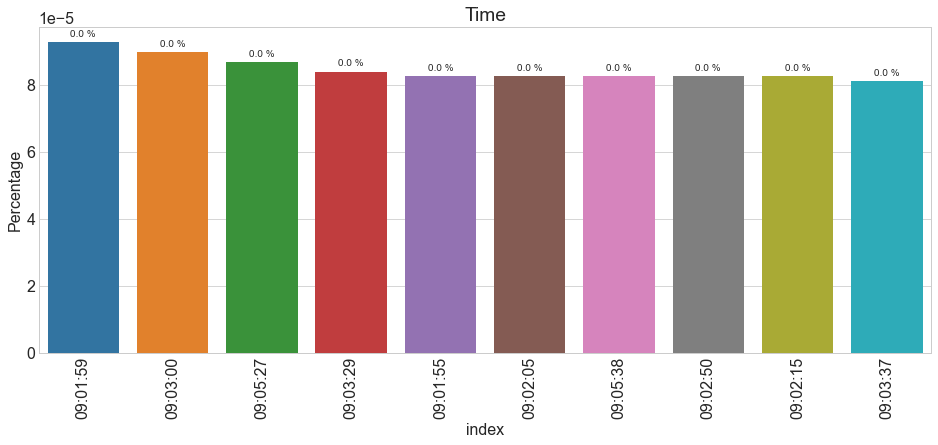

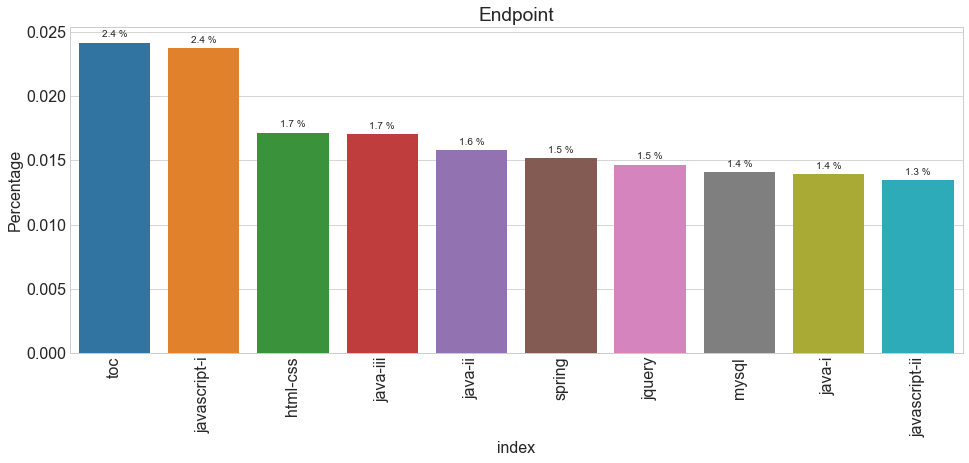

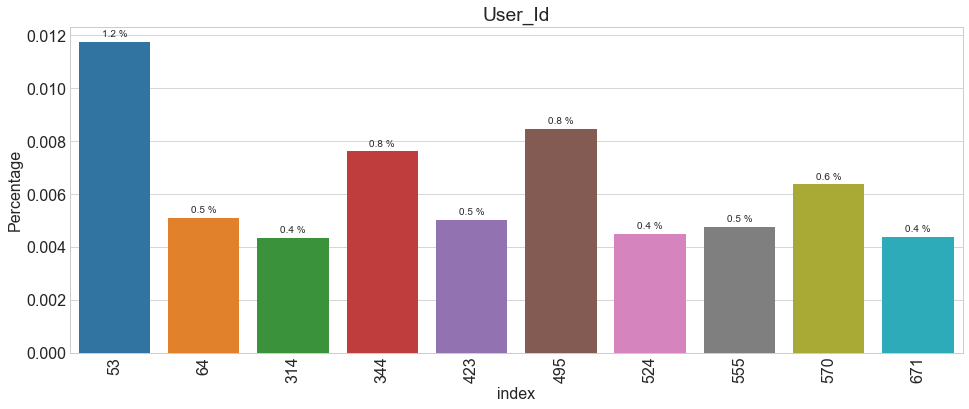

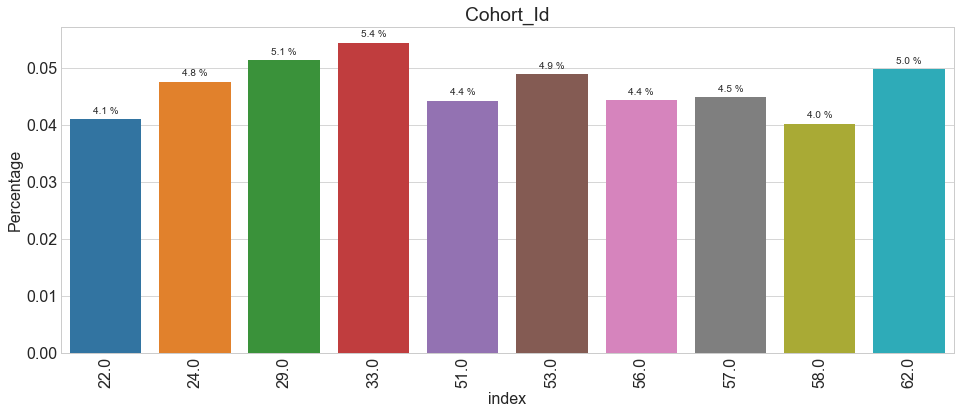

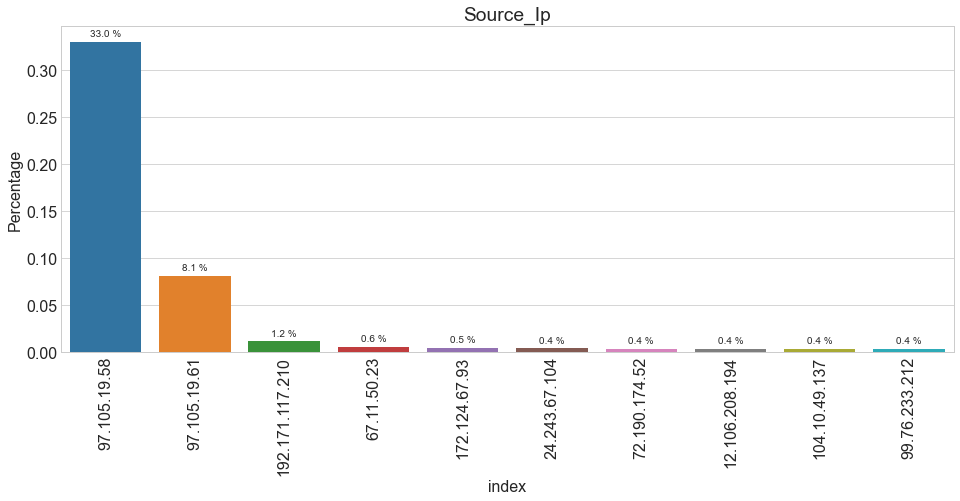

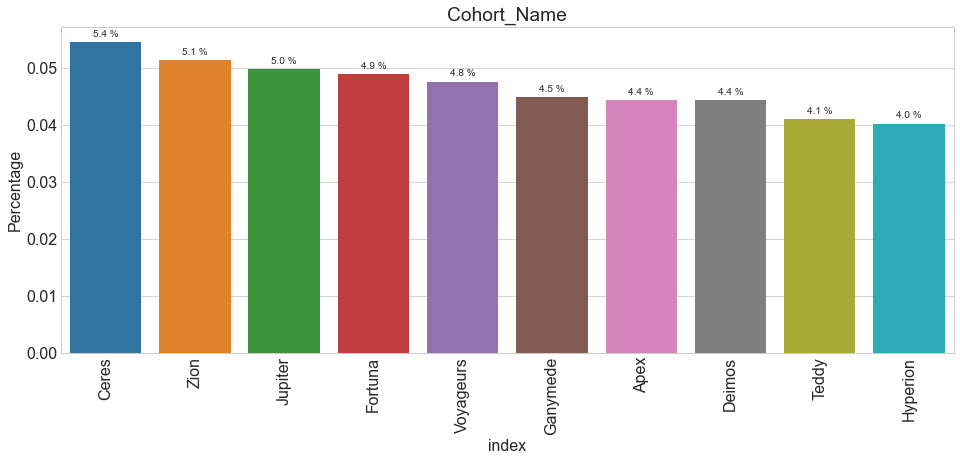

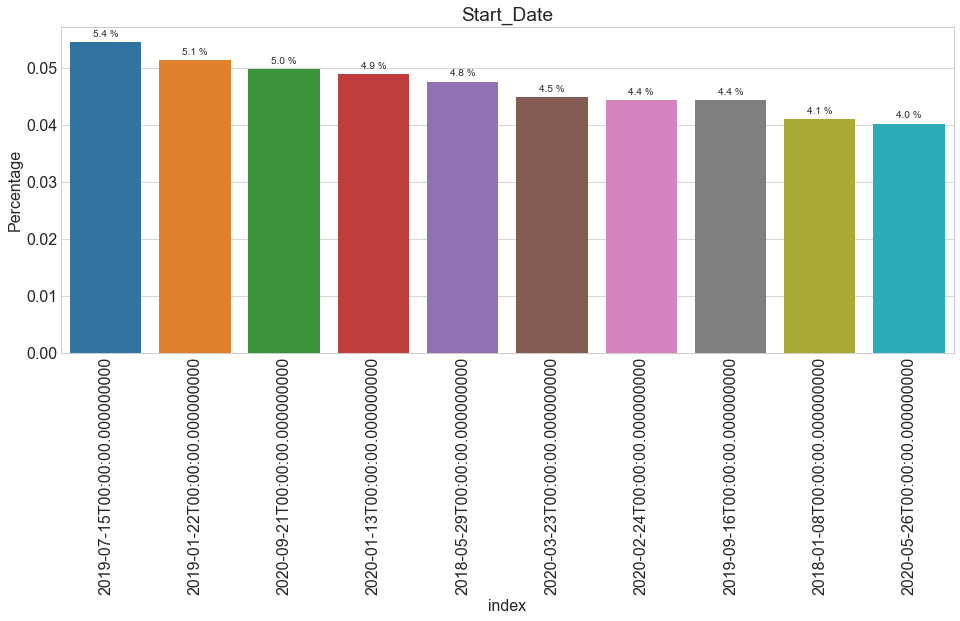

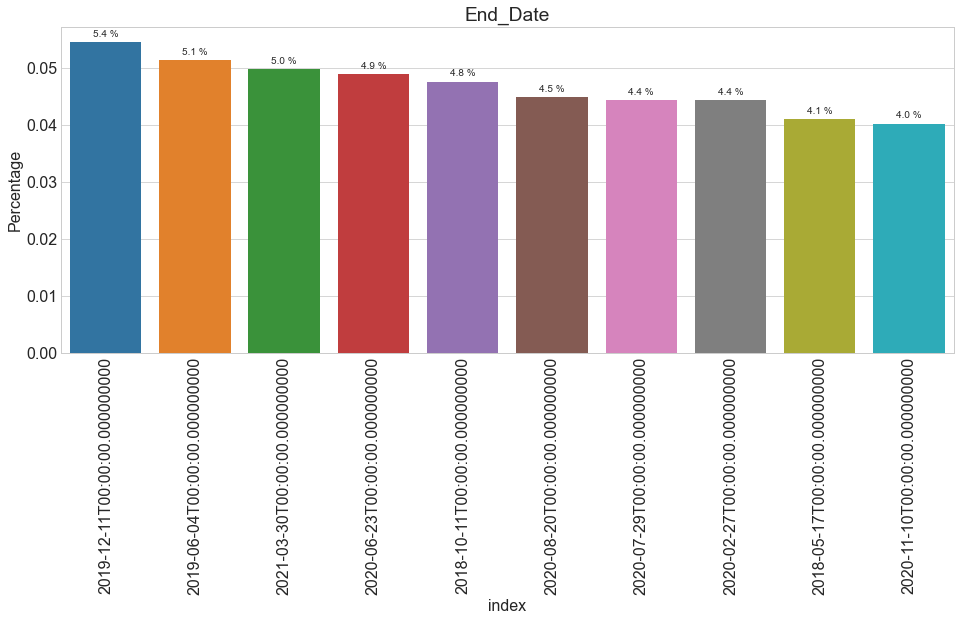

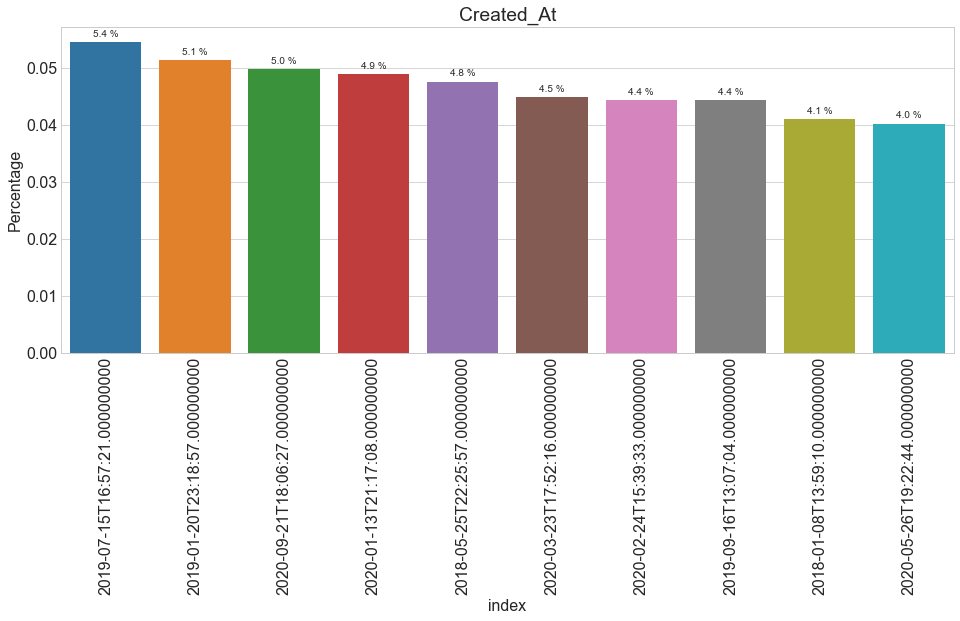

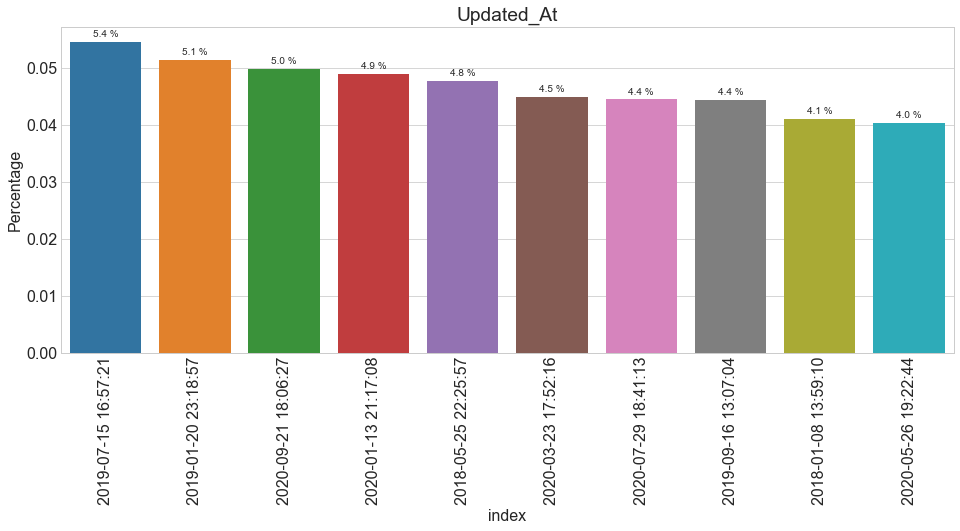

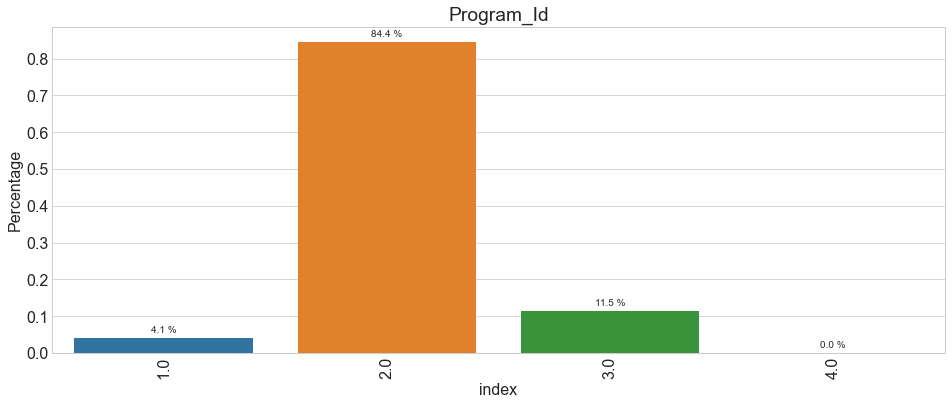

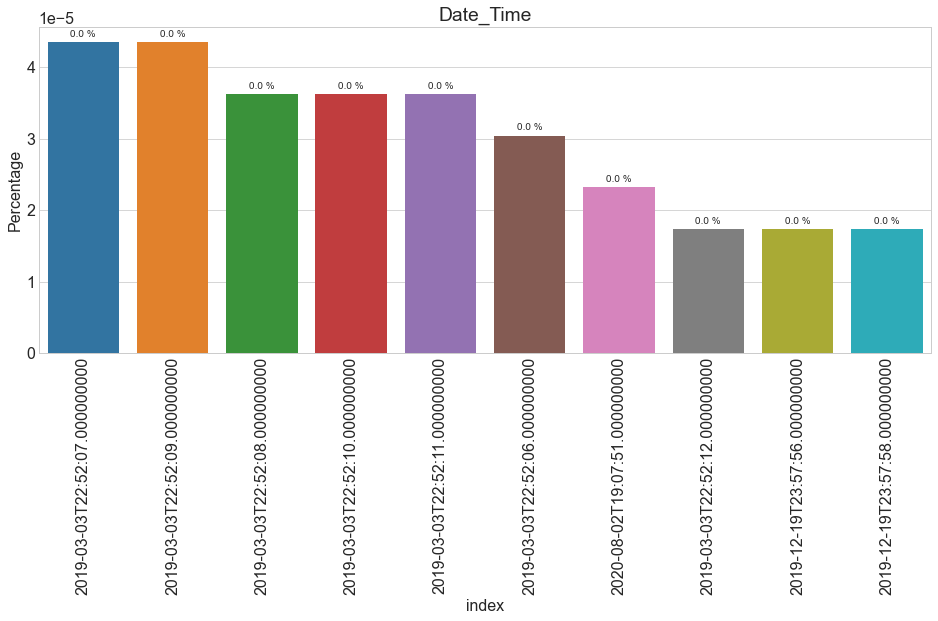

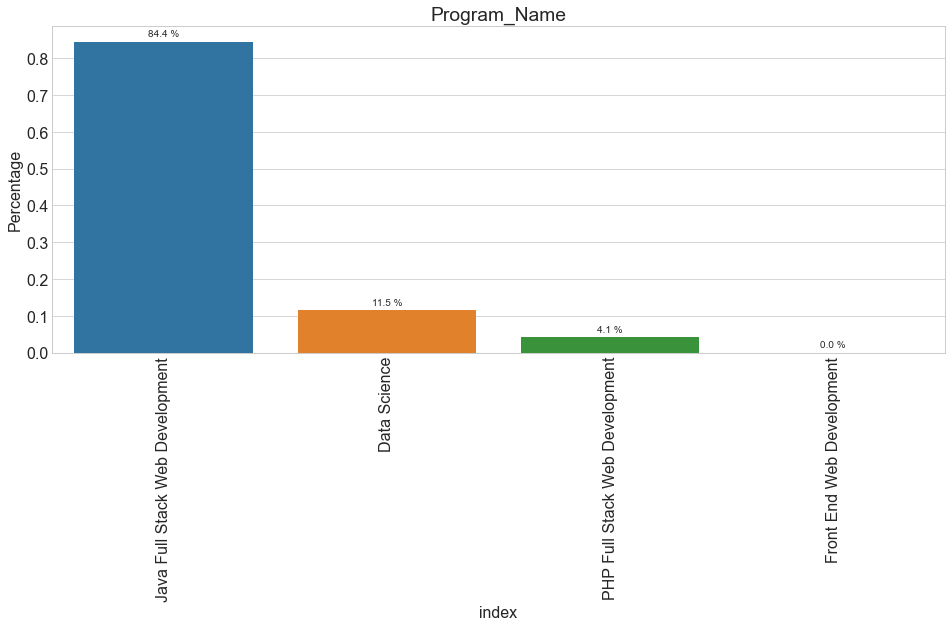

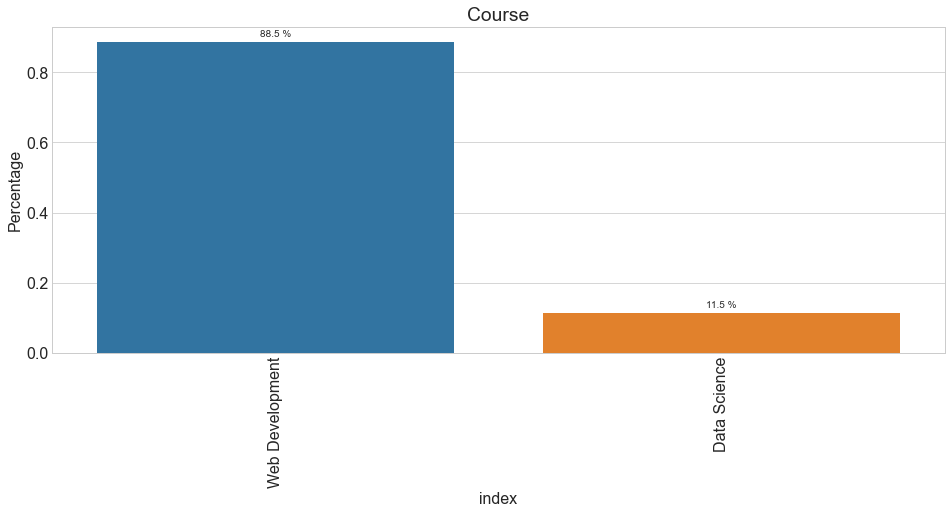

In [65]:
# let's create graphs showing the % taken by the top 10 values by each feature  
for col in df_dw.columns:
    plt.figure(figsize = (16, 6))
    splot = sns.barplot(x = 'index', y = col, data = df_dw[col].value_counts(
        normalize = True).reset_index().sort_values(by = col, ascending = False).head(10))
    for p in splot.patches:
        splot.annotate(format(p.get_height() * 100, '.1f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size = 10,  
                   xytext = (0, 8), 
                   textcoords = 'offset points')
    plt.xticks(rotation = 90)  
    plt.title(col.title())
    plt.ylabel('Percentage')
    plt.show()

# Takeaways
- Web development cohorts count for 88.5% of Codeup classtiem 

In [66]:
# most accessed endpoints by cohort 
with pd.option_context('display.max_rows', None):
    # let's remove the toc page and the slash page as it seems to be the homepage
    no_slash_toc = df_dw[(df_dw['endpoint'] != '/') & (df_dw['endpoint'] != 'toc')]
    counts = pd.DataFrame(no_slash_toc.groupby('cohort_name').endpoint.value_counts().sort_values(ascending = False))
    # let's see pages with more than 800 views.
    display(counts[counts > 800].dropna())

,,endpoint
cohort_name,endpoint,
Darden,classification/overview,1109.0
Ceres,javascript-i,1003.0
Jupiter,javascript-i,926.0
Hyperion,javascript-i,910.0
Marco,javascript-i,907.0
Zion,javascript-i,897.0
Deimos,javascript-i,896.0
Voyageurs,javascript-i,884.0
Lassen,index.html,877.0
